#Introduction

The prolblem of this report is that i need to build a model  to detect the prescence of a disease so it can help doctors identify a disease in my case breast cancer. the obecjtive of this report is to create a good Cnn model that can tell if there is or isn't breast cancer

#Research and Data Exploration

##Paper Review

The paper that I have selected to review is a paper on how to improve pseudo labeling (meaning  prediction labels for unlabeled data which is then used as labeled samples during training) using Pseudo-loss Estimation and Feature Adversarial Training to improve and make it more accurate. I think the methods for this paper are good as they warm up the model with the entire dataset and use Contrastive Learning. The authors then acknowledge that they do this to stop confirmation bias in the model. They then use a GMM(Gaussian Mixture Model) on the labeled dataset to check the loss distributions. The authors then do a cross pseudo loss to compare the loss  distributions of the labeled and unlabeled data. The authors do feature adversarial training which gives more info on the unlabeled samples to use to discriminate against bad samples. The authors then show the results of using this compared to other methods. Were PEFAT scores higher than every one. My only issue with this is that one of the methods (ACPL) they tested it against is missing the specificity and accuracy on the 20% labeled test and every metric on the 5% labeled test. I feel like they maybe could have tested it to get those metrics. Overall I feel like the results are good and they even tested this with three datasets to make sure that this did improve scores across multiple datasets instead of only having benefits on one. For the limitations one that is mentioned is in the pseudo-labeling-based SSL paradigm where it relies on model initialization on the labeled dataset and the pseudo label data from the unlabeled dataset. I picked this paper because the title of it intrigued me and I wanted to learn if they could actually boost image classification scores. I then read the paper and learned that it can and that the authors tested it quite thoroughly by testing PEFAT on three different datasets. My only real gripe with the testing is that some evaluation metrics are missing from some methods so we just have to go on good faith that the methods with missing results perform worse than PEFAT and don’t perform better. I also liked that they showed formulas to explain the calculations for each step they were doing and that they explained everything in the methods.I also think the authors showing us pseudo code steps of how their PEFAT algorithm works is really good as it helped me understand the process better. Overall I think this is a good paper and the authors did a good job explaining how PEFAT improves image classification accuracy and was tested quite thoroughly.

## Data Exploration

Dataset link : https://www.kaggle.com/datasets/hayder17/breast-cancer-detection/data

My dataset is a breast cancer tumor dataset that has 3383 mammogram images. the images are put into 3 folders valid, test and train which are used for validation, testing and training respectively. inside these 3 folder there is two folders called 0 and 1. 0 stands for Benign(meaning these are images were there is no cancer) and 1 which stands for Malignant (Meaning these images have cancer / tumor). this data set was desinged for image classification more precisely binary classification (where we predict which two labels the image belongs to and give the label to the image). the datasets images are all the same size of 640*640. I chose this dataset because as it's a medical image dataset that's designed for image classification. there was also a good amount of images in the dataset

Adding Imports that i'll need for this coursework also added np.random seed to make the random weights consistent

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
np.random.seed(1337)

it seems the other tensorflow imports are giving me issues so i'm going to install it to fix it

In [2]:
!pip install tensorflow

In [3]:
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

i'm going to use kagglehub import download code to get my dataset as i won't have to deal with unzipping the file and google drive adding ds_store to folders

In [4]:
import kagglehub

path = kagglehub.dataset_download("hayder17/breast-cancer-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-cancer-detection' dataset.
Path to dataset files: /kaggle/input/breast-cancer-detection


i want to see the folder paths and i'll set my batch size, my image size and the number of epochs for the Cnn model. i decided to set the images to 128 as you can still see details and it doesn't take up too much gpu memory

In [5]:
print(os.listdir(path))
img_size = 128
batch_size = 16
n_epochs = 25

['valid', 'test', 'train']


set file paths for the validation data, the test data, and the training data

In [6]:
valid = path + "/valid/"
test = path + '/test/'
train = path + '/train/'

I want to see the folders inside valid, train and ,test

In [7]:
print(os.listdir(valid))
print(os.listdir(test))
print(os.listdir(train))

['0', '1']
['0', '1']
['0', '1']


in the dataset 0 = Benign and 1 = Malignant


In [8]:
labels = os.listdir(valid)

Create file paths for Benign and Malignant which i call 0 and 1

In [9]:
test_0 = test+"0/"

test_1 = test+"1/"

train_0 = train+"0/"

train_1 = train+"1/"

valid_0 = valid+"0/"

valid_1 = valid+"1/"

number of images in test folder

In [10]:
print(f'The Number of benign images in Test {len(os.listdir(test_0))}')
print(f'The Number of Malignant images in Test {len(os.listdir(test_1))}')
print(f'The Number of images in Test {len(os.listdir(test_0))+len(os.listdir(test_1))}')

The Number of benign images in Test 208
The Number of Malignant images in Test 128
The Number of images in Test 336


number of images in train folder

In [11]:
print(f'The Number of benign images in Train {len(os.listdir(train_0))}')
print(f'The Number of Malignant images in Train {len(os.listdir(train_1))}')
print(f'The Number of images in Train {len(os.listdir(train_0))+len(os.listdir(train_1))}')

The Number of benign images in Train 1569
The Number of Malignant images in Train 803
The Number of images in Train 2372


number of images in valid set

In [12]:
print(f'The Number of benign images in Valid {len(os.listdir(valid_0))}')
print(f'The Number of Malignant images in Valid {len(os.listdir(valid_1))}')
print(f'The Number of images in Valid {len(os.listdir(valid_0))+len(os.listdir(valid_1))}')

The Number of benign images in Valid 448
The Number of Malignant images in Valid 227
The Number of images in Valid 675


The training, validation and test data are a bit imbalanced so i add a class weight to account for this imbalance

function to load images and make the images all the same size and smaller and also make the data an np array

In [13]:
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype="object")

now i use my function on the dataset

In [14]:
train_ds = get_training_data(train)
test_ds = get_training_data(test)
valid_ds = get_training_data(valid)

now i use np.shape to see the size of the data and if it has the right amount of columns i.e 2

In [15]:
print(f'Shape of training set{train_ds.shape}')
print(f'Shape of test set{test_ds.shape}')
print(f'Shape of validation set{valid_ds.shape}')

Shape of training set(2372, 2)
Shape of test set(336, 2)
Shape of validation set(675, 2)


now i'm going create a graph to better show/ visulaise how many benign and Malignant images there are in the training test and validation datasets

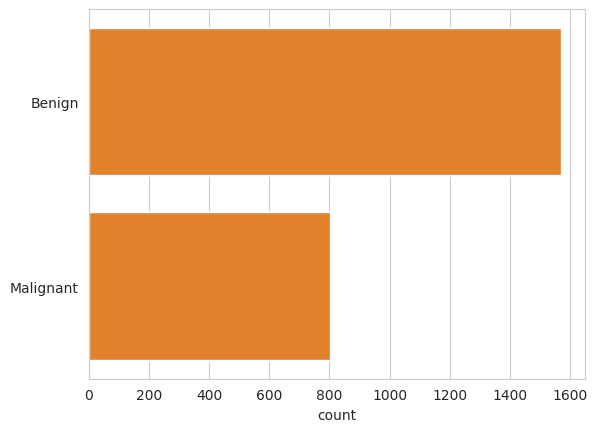

In [16]:
#create gird for training dataset
graphTrain = []

for i in train_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

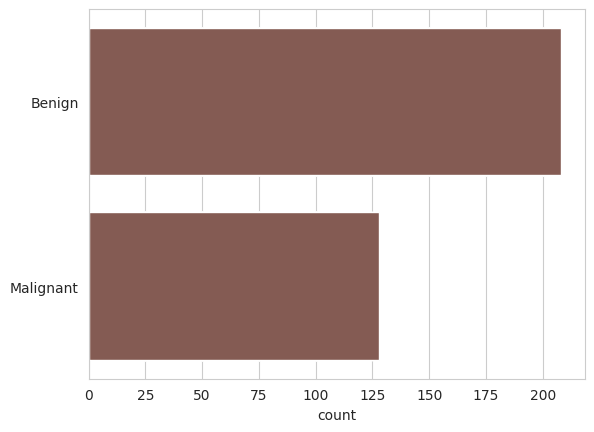

In [17]:
#create gird for test dataset
graphTrain = []

for i in test_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

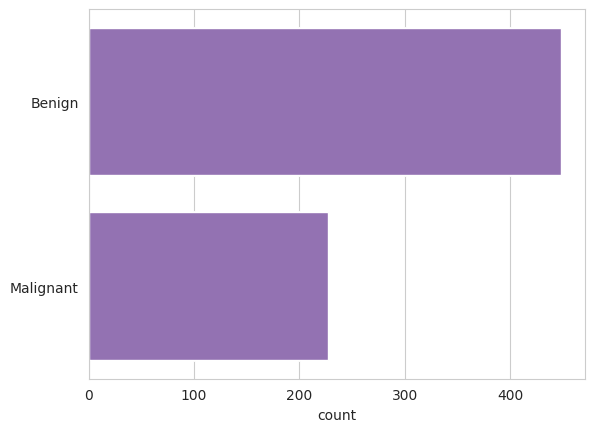

In [18]:
#create gird for valid dataset
graphTrain = []

for i in valid_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

now i'm going to create a function to show what each type of image looks likes. this function can load as many images based on the number that is passed in

In [19]:
def show_images(number, benign=True):
    plt.figure(figsize=(12,12))
    if benign == True:
        for n in range(number):
            normal_img = os.listdir(train_0)[n]
            normal_img_address = train_0+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("Benign")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_1)[n]
            pneumonia_img_address = train_1+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("Malignant")

    plt.axis("off")

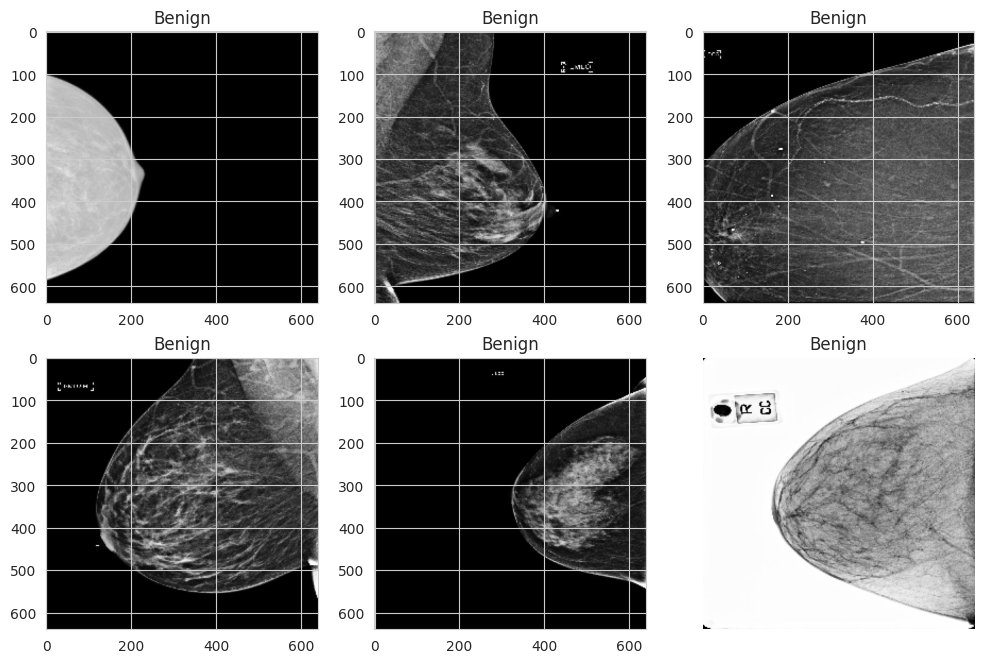

In [20]:
#show 6 bening images
show_images(6)

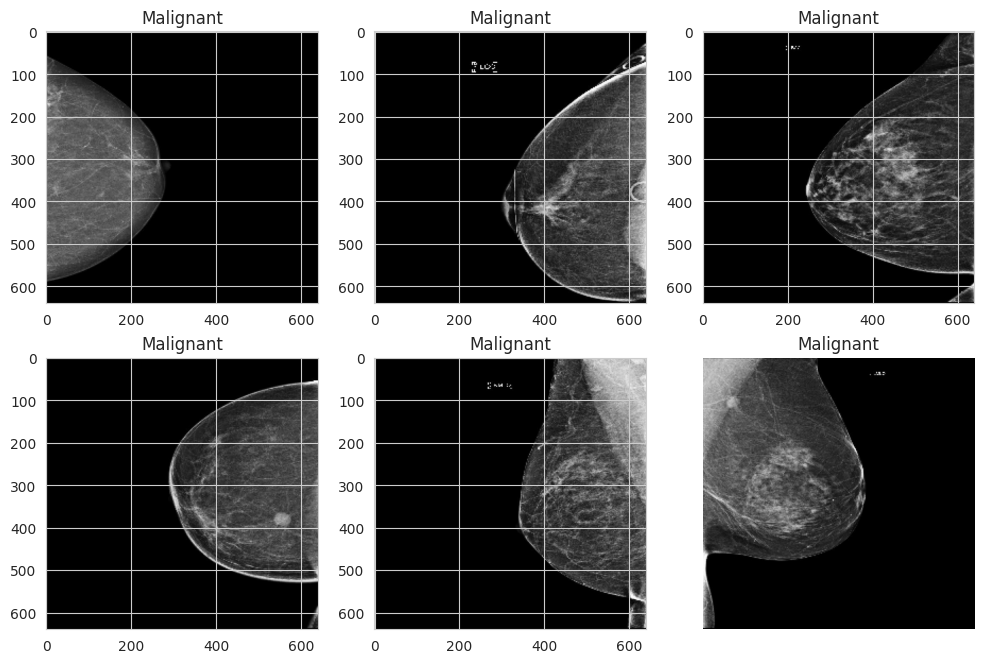

In [21]:
#show 6 Malignant images
show_images(6,False)

I'm going to apply histogram equalization to improve visualization as this can help show more diffrences

In [22]:
#!pip install scikit-image
from skimage import exposure

In [23]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [24]:
def expose_image(benign=True):
    if benign==True:
        # Choose normal random image in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_0)))
        # image file name
        img_expose_name = os.listdir(train_0)[random_img_ind]

        # path to the image
        img_expose_address = train_0+img_expose_name

        # load image
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('benign')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('benign after HE')
        plt.axis("off")
    else:
        # Choose normal random image in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_1)))
        # image file name
        img_expose_name = os.listdir(train_1)[random_img_ind]

        # path to the image
        img_expose_address = train_1+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Malignant')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Malignant after HE')
        plt.axis("off")


lets show a benign image and a Malignant image

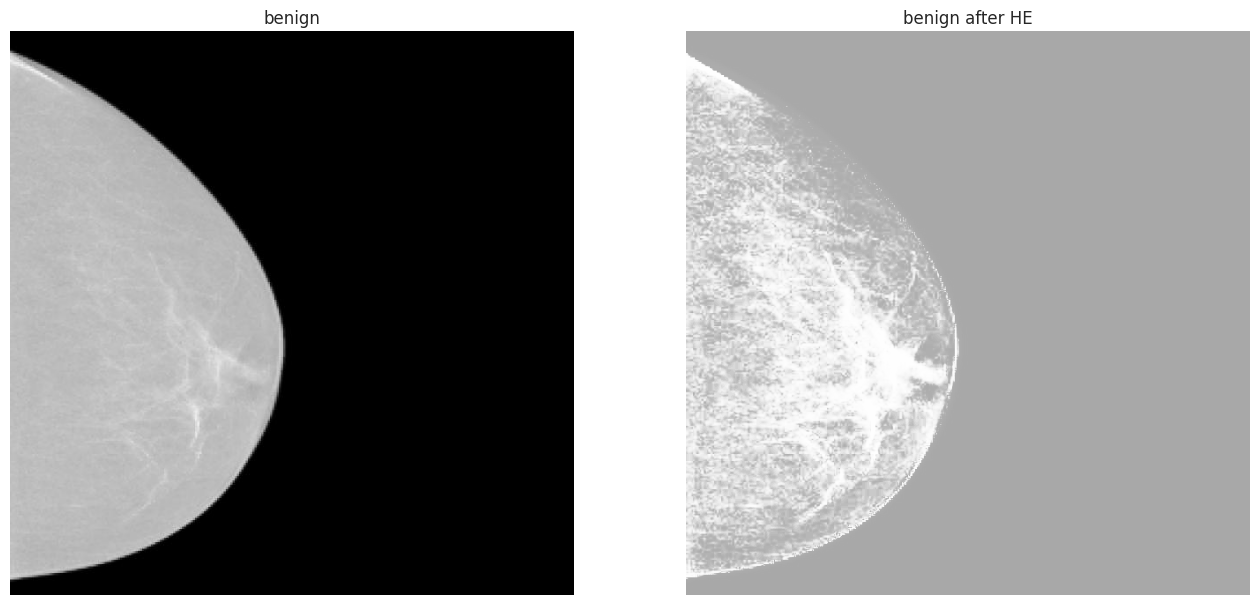

In [25]:
expose_image()

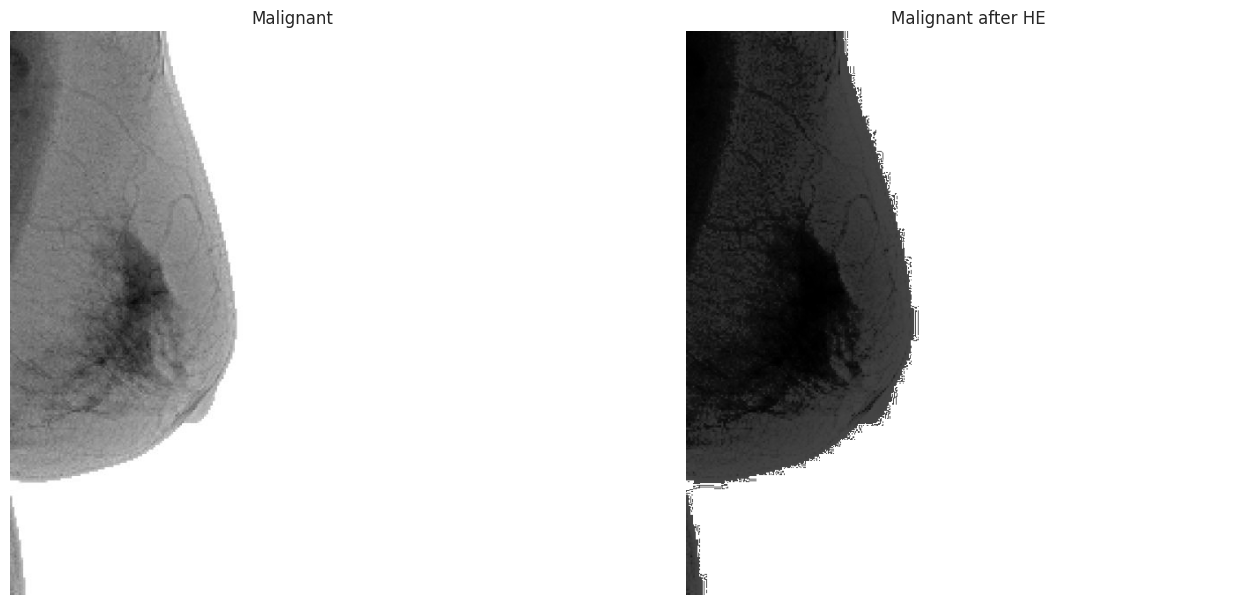

In [26]:
expose_image(False)

#Baseline Model

I now going to create a Cnn model to perform the image classification

In [27]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#loop to append images to the x and y arrays
for feature, label in train_ds:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_ds:
    x_test.append(feature)
    y_test.append(label)

for feature, label in valid_ds:
    x_val.append(feature)
    y_val.append(label)

In [28]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 2372


I'm going to normalise the data to make the variance 0 to 1 and make it more consistant to improve the models performance

In [29]:
# devide each of the x data by 255 to make it's pixel values between 0 and 1
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

I'm going to resize the array so i can perform deep learning

In [30]:
# resize the array
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

i'm using keras ImageDataGenerator to do data augmentation( which is when you create new images for the dataset by chnging them slightly i.e rotate,flip, zoom) as this should improve the performance of the model by giving it more images to work with

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(

      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      rotation_range = 30,
      zoom_range = 0.2,

      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip=False)

datagen.fit(x_train)

##CNN Model

for the Cnn model I set the optimizer to adam as it performed better when i tested it in labs and if you look on the github commits you can see that it performed better then rmsprop on this data set.

In [32]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

In [33]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 952,065 (3.63 MB)

 Trainable params: 950,977 (3.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

i need to create the weights for the model as the dataset is a bit unbalanced

In [34]:
total = len(os.listdir(train_1)) + len(os.listdir(train_0))
neg = len(os.listdir(train_0))
pos = len(os.listdir(train_1))

weight_for_0 = 1/neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.7558954748247291, 1: 1.4769613947696139}

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [36]:
# Start training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.5205 - loss: 1.1055 - val_accuracy: 0.5941 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.5365 - loss: 0.6945 - val_accuracy: 0.6430 - val_loss: 0.7694 - learning_rate: 0.0010
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.5500 - loss: 0.6931 - val_accuracy: 0.6652 - val_loss: 1.5179 - learning_rate: 0.0010
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.5893 - loss: 0.6927 - val_accuracy: 0.5007 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5880 - loss: 0.7220
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.5881 - loss: 0.7220 - val_accuracy: 0.5141 - val_loss: 0.7512 - learning_rate: 0.0010
Epoch 6/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6021 - lo

i want to see the final results

<Axes: >

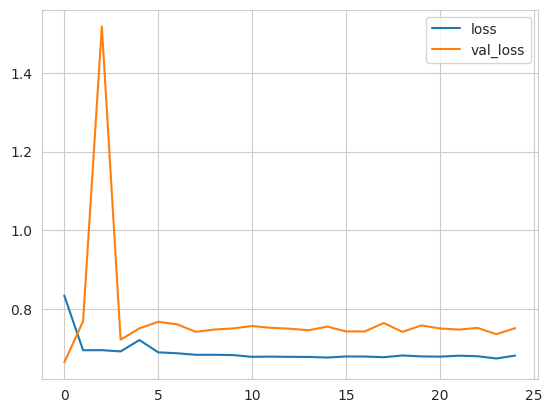

In [37]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

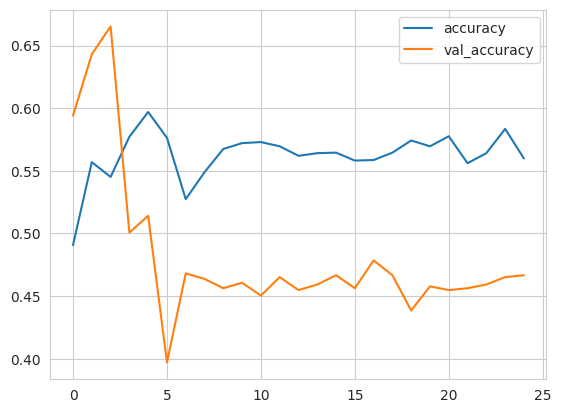

In [38]:
losses[['accuracy','val_accuracy']].plot()

i want to see what the mean of the  accuracy and mean of the loss was of the model to see if it's good

In [39]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3178 - loss: 0.8109
Loss of the model is -  0.7393512725830078
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3178 - loss: 0.8109
Accuracy of the model is -  45.23809552192688 %


now i want to see the predictions and use them to see the recall, precission and f1 score

In [40]:
predictions=model.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [41]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.65      0.25      0.36       208
Malignant (Class 1)       0.39      0.78      0.52       128

           accuracy                           0.45       336
          macro avg       0.52      0.52      0.44       336
       weighted avg       0.55      0.45      0.42       336



now i'm going to visualize this as a confusion matrix

<Axes: >

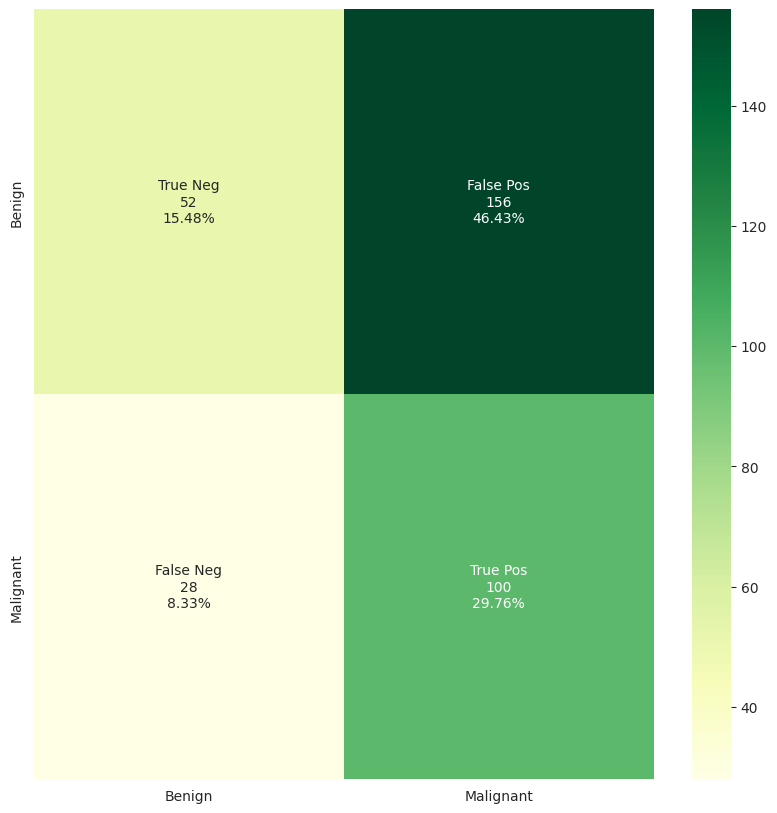

In [42]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Benign','Malignant']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

then i'll store the predictions into a data frame then make an incorrect dataframe and use it to create a manual accuracy

In [43]:
# store result into a dataframe
results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

#create incorrect dataframe
incorrect_df = results[results.Actual!=results.Predicted]
#show first five of incorrect
incorrect_df.head()

,Actual,Predicted
0,0,1
1,0,1
2,0,1
4,0,1
5,0,1


In [44]:
#manual calculation of accuracy
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 45.0 %


show the images of predictions

In [45]:
correct = np.nonzero(pred_labels == y_test)[0]
incorrect = np.nonzero(pred_labels != y_test)[0]

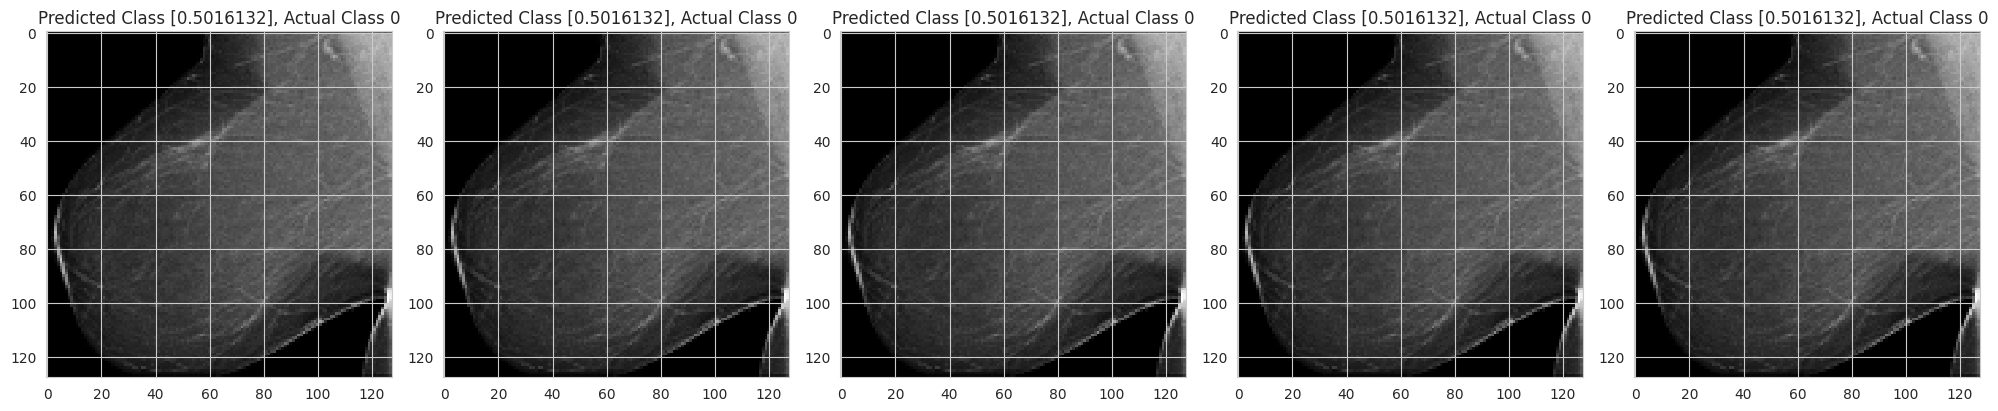

In [46]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

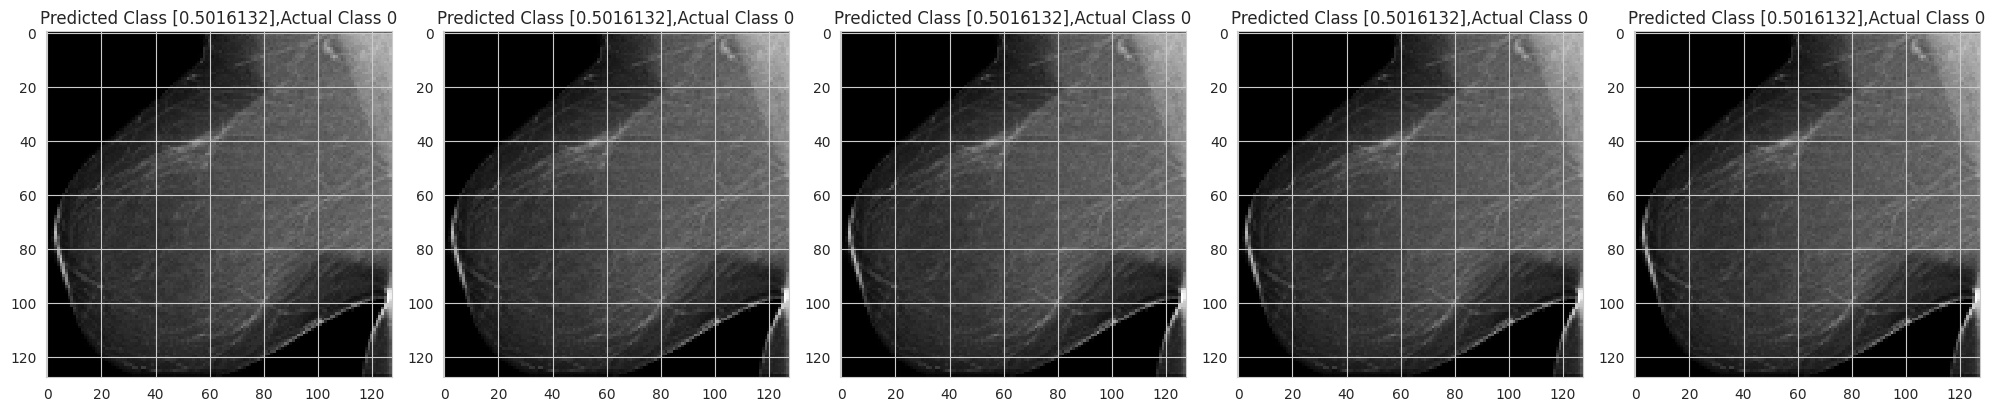

In [47]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

#Solution Improvement

i'm going to use a pre trained model to try an improve the performance as it does in most case i'll start with using InceptionV3 and VGG16 as these have both been trained with more images

In [48]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

In [49]:
# Notice 1st time this is being run, it will download the weights for the ResNet model
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [50]:
def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=output)

    return model

In [51]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 4, 4, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [52]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    class_weight = class_weight
                   )

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 64s 269ms/step - binary_accuracy: 0.4822 - loss: 0.8737 - val_binary_accuracy: 0.5289 - val_loss: 0.7552 - learning_rate: 5.0000e-05
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.6250 - loss: 0.5971 - val_binary_accuracy: 0.5274 - val_loss: 0.7473 - learning_rate: 5.0000e-05
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - binary_accuracy: 0.5046 - loss: 0.7729 - val_binary_accuracy: 0.5719 - val_loss: 0.7158 - learning_rate: 5.0000e-05
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.7500 - loss: 0.5960 - val_binary_accuracy: 0.5615 - val_loss: 0.7025 - learning_rate: 5.0000e-05
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - binary_accuracy: 0.5650 - loss: 0.7522 - val_binary_accuracy: 0.4948 - val_loss: 0.7666 - learning_rate: 5.0000e-05
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.5000 - loss: 0.7326 - val_binary_accuracy: 0.5570 - val_loss: 0.7

<Axes: >

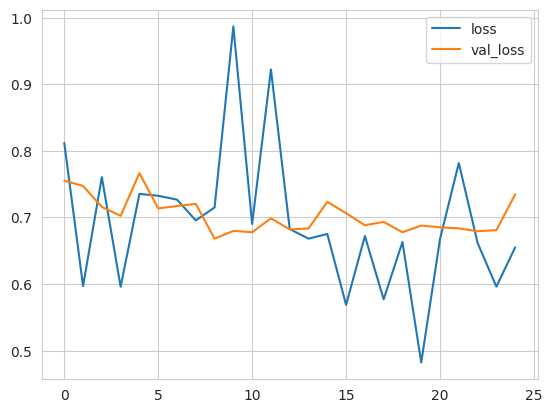

In [53]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

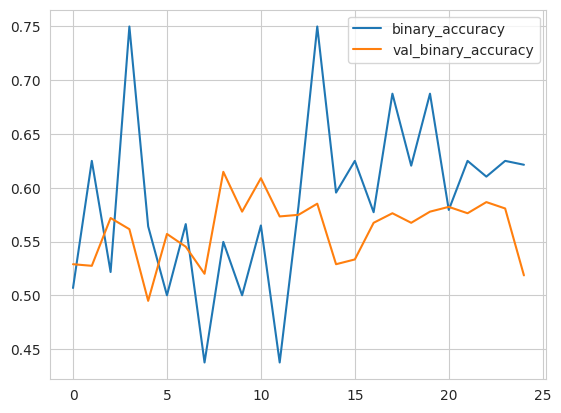

In [54]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [55]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - binary_accuracy: 0.4153 - loss: 0.8014
Loss of the model is -  0.7316546440124512
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.4153 - loss: 0.8014
Accuracy of the model is -  50.59523582458496 %


Fine Tunning

i'm going to fine tune the model as this can improve perfromance

In [56]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [57]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 4, 4, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 3,678,465 (14.03 MB)

 Non-trainable params: 54,915,584 (209.49 MB)

In [58]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    class_weight = class_weight
                   )

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 65s 253ms/step - binary_accuracy: 0.6449 - loss: 0.7006 - val_binary_accuracy: 0.6178 - val_loss: 0.6506 - learning_rate: 2.0000e-06
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.1875 - loss: 0.7883 - val_binary_accuracy: 0.5807 - val_loss: 0.6864 - learning_rate: 2.0000e-06
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - binary_accuracy: 0.6409 - loss: 0.6718 - val_binary_accuracy: 0.6296 - val_loss: 0.6564 - learning_rate: 2.0000e-06
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.6875 - loss: 0.7491 - val_binary_accuracy: 0.6044 - val_loss: 0.6738 - learning_rate: 2.0000e-06
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - binary_accuracy: 0.6295 - loss: 0.6760 - val_binary_accuracy: 0.6015 - val_loss: 0.6499 - learning_rate: 2.0000e-06
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.4375 - loss: 0.7784 - val_binary_accuracy: 0.6000 - val_loss: 0.6

In [59]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - binary_accuracy: 0.5722 - loss: 0.6918
Loss of the model is -  0.6890448927879333
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.5722 - loss: 0.6918
Accuracy of the model is -  56.84523582458496 %


In [60]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


<Axes: >

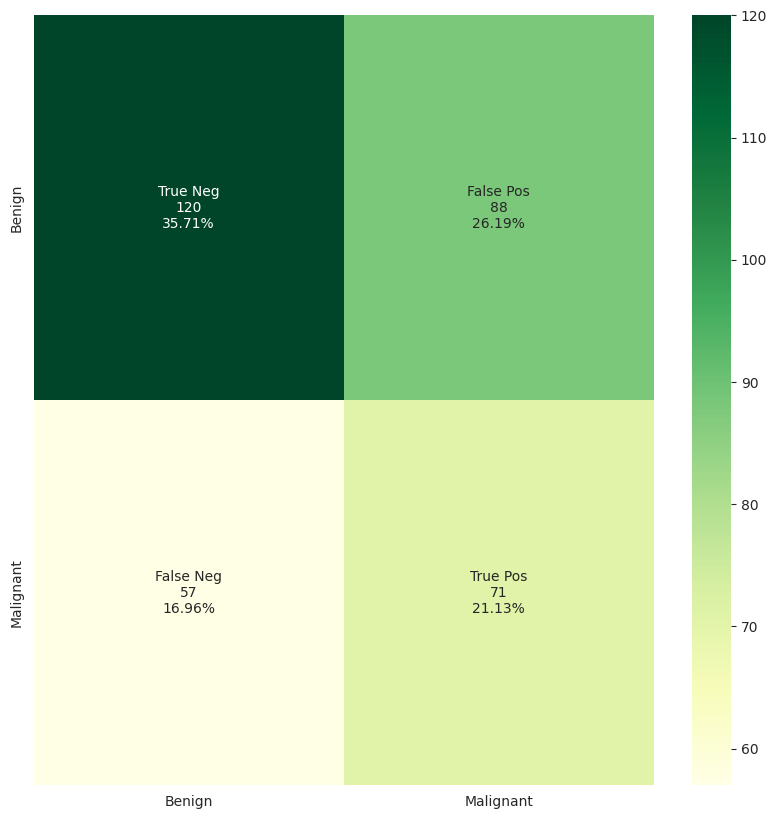

In [61]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

#Conclusion and Future Direction